# data preprocessing

In [60]:
import io
import pickle
import re
from collections import Counter
from shutil import rmtree

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorboard.plugins import projector
from PIL import Image
from soynlp.normalizer import repeat_normalize
from tqdm.notebook import tqdm
from wordcloud import WordCloud

from tokenizer import Tokenizer
from utils import load_json, save_pickle


cfg = load_json("config.json")

In [34]:
from khaiii_utils import get_khaiii_api, pos_text, stemming_text
api = get_khaiii_api('/mnt/subdisk/workspace/khaiii/build/share/khaiii')

In [35]:
df = pd.read_excel("resource/ine_coment.xlsx")
df.head()

,title,desc,name,time,comment
0,방송의 5할이 먹는 이야기라네,20210913. 20211024 아이네의 최애 버거는? 아이네 생방송: http...,ᄋᄋ,2021-11-12 03:04:35,아이네님 먹는 경양식 돈까스 브랜드가 뭔지 알 수 있을까요?
1,방송의 5할이 먹는 이야기라네,20210913. 20211024 아이네의 최애 버거는? 아이네 생방송: http...,Gsg Shim,2021-11-12 02:32:24,아웃트로 음악 뭔지 아시는분 ㅜㅠ
2,방송의 5할이 먹는 이야기라네,20210913. 20211024 아이네의 최애 버거는? 아이네 생방송: http...,루미더스,2021-11-12 02:12:40,최애 버거에 대한 진심이 느겨지는 영상 입니닼ㅋㅋㅋ
3,방송의 5할이 먹는 이야기라네,20210913. 20211024 아이네의 최애 버거는? 아이네 생방송: http...,쵸핑,2021-11-12 00:08:23,"색깔 취향 확고, 음식 취향 확고 등... 종합해보면 아이네님의 덕력은 역시 이세돌..."
4,방송의 5할이 먹는 이야기라네,20210913. 20211024 아이네의 최애 버거는? 아이네 생방송: http...,짬통,2021-11-11 23:49:58,"""복에 겨워서 감흥이 없어요"" ""냔냔냐! 냔냔냐냐!!"""


In [36]:
def normalize(text):
    text = text.replace("_x000D_", " ")
    text = text.replace("\n", " ")
    text = text.replace("넴", "님")
    text = text.replace("넘", "님")
    text = text.replace("는데", "다")
    text = text.replace("아니네", "아이네")
    text = text.replace("해미네", "햄이네")
    text = re.sub("http[s]?://(?:[a-zA-Z]|[0-9]|[$\-@\.&+:/?=]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", "", text)
    text = re.sub(r'\d+(:\d+)+|[^ 가-힣0-9]', r' ', text)
    text = repeat_normalize(text, 3)
    text = re.sub(r'(.{3,}?)\1+', r'\1', text)
    return text.strip()

df = df[df['name'] != '아이네 INE']
df['comment'] = df['comment'].apply(normalize)
df = df[df['comment'].str.len() > 1]
df.head(5)

,title,desc,name,time,comment
0,방송의 5할이 먹는 이야기라네,20210913. 20211024 아이네의 최애 버거는? 아이네 생방송: http...,ᄋᄋ,2021-11-12 03:04:35,아이네님 먹는 경양식 돈까스 브랜드가 뭔지 알 수 있을까요
1,방송의 5할이 먹는 이야기라네,20210913. 20211024 아이네의 최애 버거는? 아이네 생방송: http...,Gsg Shim,2021-11-12 02:32:24,아웃트로 음악 뭔지 아시는분
2,방송의 5할이 먹는 이야기라네,20210913. 20211024 아이네의 최애 버거는? 아이네 생방송: http...,루미더스,2021-11-12 02:12:40,최애 버거에 대한 진심이 느겨지는 영상 입니닼
3,방송의 5할이 먹는 이야기라네,20210913. 20211024 아이네의 최애 버거는? 아이네 생방송: http...,쵸핑,2021-11-12 00:08:23,색깔 취향 확고 음식 취향 확고 등 종합해보면 아이네님의 덕력은 역시 이세돌 최강인...
4,방송의 5할이 먹는 이야기라네,20210913. 20211024 아이네의 최애 버거는? 아이네 생방송: http...,짬통,2021-11-11 23:49:58,복에 겨워서 감흥이 없어요 냔냔냐냐


In [37]:
pos_tagged_corpus = pos_text(df.comment, api)
df['processed_comment'] = stemming_text(pos_tagged_corpus)

In [39]:
df['processed_comment'] = df['processed_comment'].apply(
    lambda x: ' '.join(
        [
            w.split('/')[0] 
            for w in x.split() 
            if w.split('/')[1] in ['NNG', 'NNP', 'VV', 'VA', 'MAG', 'MAJ']
        ]
    )
)
df = df[df['processed_comment'] != ""]
df.head()

,title,desc,name,time,comment,processed_comment
0,방송의 5할이 먹는 이야기라네,20210913. 20211024 아이네의 최애 버거는? 아이네 생방송: http...,ᄋᄋ,2021-11-12 03:04:35,아이네님 먹는 경양식 돈까스 브랜드가 뭔지 알 수 있을까요,아이네 먹다 경양식 돈까스 브랜드 알다 있다
1,방송의 5할이 먹는 이야기라네,20210913. 20211024 아이네의 최애 버거는? 아이네 생방송: http...,Gsg Shim,2021-11-12 02:32:24,아웃트로 음악 뭔지 아시는분,아웃트 음악 알다
2,방송의 5할이 먹는 이야기라네,20210913. 20211024 아이네의 최애 버거는? 아이네 생방송: http...,루미더스,2021-11-12 02:12:40,최애 버거에 대한 진심이 느겨지는 영상 입니닼,최애 버거 대하다 진심 느다 기 지다 영상 입
3,방송의 5할이 먹는 이야기라네,20210913. 20211024 아이네의 최애 버거는? 아이네 생방송: http...,쵸핑,2021-11-12 00:08:23,색깔 취향 확고 음식 취향 확고 등 종합해보면 아이네님의 덕력은 역시 이세돌 최강인...,색깔 취향 확고 음식 취향 확고 종합하다 보다 아이네 덕력 역시 이세돌 최강인 같
4,방송의 5할이 먹는 이야기라네,20210913. 20211024 아이네의 최애 버거는? 아이네 생방송: http...,짬통,2021-11-11 23:49:58,복에 겨워서 감흥이 없어요 냔냔냐냐,복 겹 감흥 없 냔다


In [40]:
df.to_excel("resource/preprecessed_ine_coment.xlsx", index=None)

In [2]:
df = pd.read_excel("resource/preprecessed_ine_coment.xlsx")

# draw wordcloud

In [3]:
all_tokens = sum(df['processed_comment'].apply(lambda x: x.split()), [])

In [4]:
counter = Counter(all_tokens)

counter.most_common(10)

[('아이네', 1425),
 ('너무', 982),
 ('좋', 818),
 ('하다', 801),
 ('보다', 778),
 ('있다', 441),
 ('진짜', 428),
 ('킹아', 393),
 ('주다', 348),
 ('귀엽', 347)]

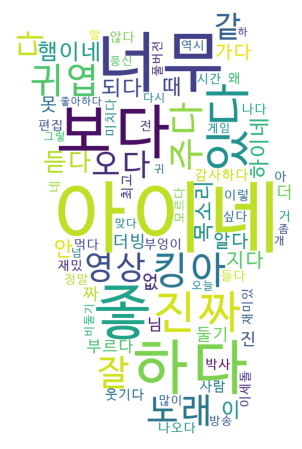

In [5]:
bgimg = Image.open('resource/wakdoo.png')
mask = np.array(bgimg)

wc = WordCloud(font_path="resource/D2Coding.ttf",background_color="white", max_font_size=200, mask=mask)
cloud = wc.generate_from_frequencies(dict(counter.most_common(80)))
cloud.to_file("resource/wordcloud.png")

plt.figure(figsize=(10, 8))
plt.axis('off')
plt.imshow(cloud)
plt.show()

# tokenizer

In [6]:
tokens = ["[PAD]", "[UNK]"] + [t[0] for t in counter.most_common(len(counter))]

save_pickle({k: i for i, k in enumerate(tokens)}, "resource/tokenizer.pkl")

In [7]:
tokenizer = Tokenizer("resource/tokenizer.pkl")

In [8]:
sample_text = df.iloc[0, -1]

print(sample_text)
print(tokenizer.encode(sample_text))

아이네 먹다 경양식 돈까스 브랜드 알다 있다
[2, 55, 1271, 1584, 3146, 28, 7]


# word 2 Vec

## data setting

In [9]:
targets, contexts, labels = [], [], []

sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(tokenizer.vocab_size)

In [10]:
for text in tqdm(df.processed_comment):
    sequence = tokenizer.encode(text)
    if len(sequence) < cfg['num_negative_samples'] * 2 + 1:
        continue
    
    positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
        sequence,
        vocabulary_size=tokenizer.vocab_size,
        sampling_table=sampling_table,
        window_size=cfg['window_size'],
        negative_samples=0
    )

    for target_word, context_word in positive_skip_grams:
        context_class = tf.expand_dims(tf.constant([context_word], dtype="int64"), 1)
        negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
            true_classes=context_class,
            num_true=1,
            num_sampled=cfg['num_negative_samples'],
            unique=True,
            range_max=tokenizer.vocab_size,
            seed=cfg['random_seed'],
            name="negative_sampling"
        )

        negative_sampling_candidates = tf.expand_dims(negative_sampling_candidates, 1)

        context = tf.concat([context_class, negative_sampling_candidates], 0)
        label = tf.constant([1] + [0] * cfg['num_negative_samples'], dtype="int64")

        targets.append(target_word)
        contexts.append(context)
        labels.append(label)

  0%|          | 0/7740 [00:00<?, ?it/s]

In [11]:
targets = np.array(targets)
contexts = np.array(contexts)[:,:,0]
labels = np.array(labels)

targets.shape, contexts.shape, labels.shape

((14386,), (14386, 5), (14386, 5))

In [12]:
BATCH_SIZE = 1024
BUFFER_SIZE = 10000

dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
dataset = dataset.shuffle(BUFFER_SIZE).batch(cfg['batch_size'], drop_remainder=True)

print(dataset, len(dataset))

<BatchDataset shapes: (((512,), (512, 5)), (512, 5)), types: ((tf.int32, tf.int64), tf.int64)> 28


## model define

In [65]:
class Word2Vec(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size):
        super(Word2Vec, self).__init__()
        
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        
#         self.embedding = tf.keras.layers.Embedding(
#             vocab_size,
#             embedding_size,
#         )

        self.target_embedding = tf.keras.layers.Embedding(
            vocab_size,
            embedding_size,
        )

        self.context_embedding = tf.keras.layers.Embedding(
            vocab_size,
            embedding_size,
        )

    def call(self, pair):
        target, context = pair
        
        if len(target.shape) == 2:
            target = tf.squeeze(target, axis=1)

#         word_emb = self.embedding(target)
#         context_emb = self.embedding(context)
        word_emb = self.target_embedding(target)
        context_emb = self.context_embedding(context)
        output = tf.einsum('be,bce->bc', word_emb, context_emb)

        return output

    def get_config(self):
        return {
            "vocab_size": self.vocab_size,
            "embedding_size": self.embedding_size,
        }

In [66]:
word2vec = Word2Vec(tokenizer.vocab_size, cfg['embedding_size'])
word2vec.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

## train

In [67]:
rmtree("logs")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs", update_freq='batch')

In [68]:
word2vec.fit(dataset, epochs=cfg['epochs'], callbacks=[tensorboard_callback], verbose=0)

## visualize

In [44]:
%load_ext tensorboard
%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 20540), started 2:43:17 ago. (Use '!kill 20540' to kill it.)

https://projector.tensorflow.org/

In [69]:
weights = word2vec.target_embedding.get_weights()[0]
# weights = word2vec.embedding.get_weights()[0]

out_v = io.open('resource/vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('resource/metadata.tsv', 'w', encoding='utf-8')

for index, word in tokenizer.id_to_word.items():
    if index < 2:
        continue  # skip 0, it's padding.
    vec = weights[index]
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
    out_m.write(word + "\n")
    
out_v.close()
out_m.close()